# Análise dos dados obtidos

In [1]:
# Imports
#  /home/bradachi/Documentos/GitHub/NLP_teste/NLP_ENV/bin/python -m pip install 
import requests
import json
import pprint
import pandas as pd
import lxml
import time
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
import string
import matplotlib.pyplot as plt 
from textblob import TextBlob
from bertopic import BERTopic
from PIL import Image
import numpy as np
from LeIA import SentimentIntensityAnalyzer
# from selenium import webdriver
# from webdriver_manager.firefox import GeckoDriverManager 
# from selenium.webdriver.firefox.service import Service 
# from selenium.webdriver.common.action_chains import ActionChains
# from selenium.webdriver.common.keys import Keys
# from selenium.common.exceptions import NoSuchElementException


[nltk_data] Downloading package punkt to /home/bradachi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/bradachi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bradachi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/bradachi/Documentos/GitHub/NLP_teste/NLP_ENV/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
objects_list = [
"sensores",
"Comedouro Automático",
"guarda roupa inteligente",
"panela inteligente",
"geladeira inteligente",
"cocho inteligente",
"freezer inteligente",
"silo inteligente",
"ar-condicionado inteligente",
"aquecedor inteligente",
"ventilador inteligente",
"Termostato digital",
"fogão inteligente",
"fritadeira a ar inteligente",
"forno inteligente",
"janela inteligente",
"cortina inteligente",
"tomada inteligente",
"aspersor inteligente",
"controlador de irrigação inteligente",
"chuveiro inteligente",
"dispensador de água inteligente",
"filtro de água inteligente",
"estação de tratamento múltipla",
"smartwatch",
"óculos de realidade virtual",
"capacete inteligente",
"anel inteligente",
"colar inteligente",
"cinto inteligente",
"brinco inteligente",
"máscara inteligente",
"monitor de glicose inteligente",
"coleira inteligente",
"bota inteligente",
"fones de ouvido inteligentes",
"prótese inteligente",
"aparelho auditivo inteligente",
"microfone inteligente",
"sonar inteligente",
"cerca elétrica inteligente",
"sensor de perímetro",
"Computador",
"televisão inteligente",
"decodificador inteligente",
"reprodutor de mídia",
"painel de exibição inteligente",
"telemetria inteligente",
"projetor inteligente"
# "totem de autoatendimento",
"inteligente projetor",
"quadro branco inteligente",
# "totem de informações",
"patinete elétrico inteligente",
"robô de colheita",
"braço robótico",
"robô de capina",
"interruptor de luz inteligente",
"Disjuntor automático inteligente",
"secadora de roupas inteligente",
"máquina de lavar roupa inteligente",
"dispensador de comprimidos inteligente",
"lâmpada inteligente",
"RFID",
"Drone",
"impressora 3D inteligente",
"impressora inteligente",
"tapete inteligente",
"caixa de som inteligente",
"espelho inteligente",
"porta inteligente",
"fechadura inteligente",
"câmera inteligente",
"equipamento médico inteligente Kit",
"câmera",
"cafeteira inteligente",
"Google Nest",
"Asistentes pessoais",
"Alexa",
"Echo",
"HomeKit",
"Siri",
"Xiaomi smart home",
"Philips Hue",
"Intelbras smart home",
"Intelbras casa inteligente",
"Positivo Casa Inteligente",
"Multilaser",
"Fitbit",
"LG smart home",
"Tuya"
]
len(objects_list)

88

In [2]:
perguntas = pd.read_csv("perguntas.csv")
perguntas = perguntas.drop_duplicates().reset_index(drop=True)
perguntas

,pergunta,resposta,id,data
0,Minha cervejeira é VN28AF Termostato sollatek ...,"Boa tarde, seu termostato saiu de linha o subs...",MLB44743999,27/11/2025
1,Esse termostato tem os 4 pinos?,"Boa tarde, são 6 pinos porem os que tem função...",MLB44743999,26/11/2025
2,Teria para o modelo VF56DB 220V,"Boa tarde, seu modelo usa termostato sollatek,...",MLB44743999,26/06/2025
3,Ok ele e 220v,O termostato do anúncio é bivolt.,MLB44743999,15/05/2025
4,Bom dia ele serve para o modelo vb15 metal frio,"Bom dia, sim temos programações para expositor...",MLB44743999,16/05/2025
...,...,...,...,...
56460,Olá é luz quente,"Olá Tudo bem? Não, a luz é branco neutro 4000k...",MLB46936892,02/09/2025
56461,Precisso da nota fiscal de este produto,Olá boa tarde! Tudo bem? Claro! Pode nos envia...,MLB46936892,23/06/2025
56462,"Muito obrigado pela atenção, E27 que preciso. ...",Deu certo o Sr. conseguiu utilizar?,MLB46936892,29/05/2025
56463,Comprei chegou mas a rosca não é E27 é menor,Boa noite! Tudo bem? Mas esse modelo não temos...,MLB46936892,28/05/2025


In [3]:
avaliacoes = pd.read_csv("avaliacoes.csv")
avaliacoes = avaliacoes.drop_duplicates().reset_index(drop=True)
avaliacoes

,texto,nota,id,data
0,Excelente produto!!.,5,MLB46241561,09 out. 2025
1,Muito bom.,5,MLB48090512,15 out. 2025
2,Muito bom produto.,5,MLB48090512,16 out. 2025
3,Produto bom. Sem retorno.,5,MLB48090512,20 nov. 2025
4,Produto confiável e original. Eu mesmo arrumei...,5,MLB29176649,27 out. 2025
...,...,...,...,...
17737,Maravilhosa.,5,MLB25814527,20 nov. 2025
17738,É elogiado por sua integração eficaz com siste...,5,MLB25814527,20 nov. 2025
17739,Veio certinho está funcionando bem.,5,MLB25814527,31 mar. 2025
17740,É amplamente elogiado por sua facilidade de us...,5,MLB24689330,20 nov. 2025


In [4]:
produtos = pd.read_csv("caracteristicas.csv")
id_domain = produtos[["id", "domain_id"]]

avaliacao_domain = pd.merge(avaliacoes, id_domain, on='id', how='inner')

avaliacao_domain['domain_id'].value_counts()[:10]



domain_id
MLB-SMART_SPEAKERS                 2215
MLB-HOME_ALARMS_AND_SENSORS        1152
MLB-DIMMERS                         975
MLB-WATER_PURIFIERS_AND_FILTERS     889
MLB-BOOTS_AND_BOOTIES               795
MLB-COOKTOPS                        646
MLB-ELECTRIC_ENTRANCE_INTERCOMS     546
MLB-TELEVISIONS                     544
MLB-ELECTRICAL_OUTLETS              516
MLB-SURVEILLANCE_CAMERAS            440
Name: count, dtype: int64

In [5]:
perguntas_domain = pd.merge(perguntas, id_domain, on='id', how='inner')

perguntas_domain['domain_id'].value_counts()[:10]

domain_id
MLB-TELEVISIONS                5724
MLB-COOKTOPS                   4007
MLB-DIMMERS                    3552
MLB-SMART_SPEAKERS             3039
MLB-VR_HEADSETS                2241
MLB-OVENS                      2062
MLB-SURVEILLANCE_CAMERAS       2057
MLB-HOME_ALARMS_AND_SENSORS    1959
MLB-HOME_GYMS                  1944
MLB-SMARTWATCHES               1861
Name: count, dtype: int64

In [6]:
smartObjects = pd.read_csv("contexto.csv")

wifiObjects = smartObjects[smartObjects["Context_Id"] == "WITH_WI_FI"]
bltObjects = smartObjects[smartObjects["Context_Id"] == "WITH_BLUETOOTH"]

smartObjects = pd.concat([wifiObjects, bltObjects])

smartObjects = smartObjects[smartObjects["value_name"] == "Sim"]

smartObjects = smartObjects["id"].drop_duplicates().reset_index(drop=True)
smartObjects = list(smartObjects)
smartObjects

['MLB36333923',
 'MLB36139109',
 'MLB21345002',
 'MLB38703841',
 'MLB36398531',
 'MLB54448099',
 'MLB48677687',
 'MLB19552926',
 'MLB27839322',
 'MLB28002506',
 'MLB56994543',
 'MLB29568434',
 'MLB26446377',
 'MLB38750127',
 'MLB54236783',
 'MLB41626835',
 'MLB24455199',
 'MLB57356995',
 'MLB27985244',
 'MLB28682642',
 'MLB43616708',
 'MLB27769043',
 'MLB34345595',
 'MLB28754492',
 'MLB61666608',
 'MLB40002972',
 'MLB25735509',
 'MLB41799760',
 'MLB39171159',
 'MLB28037061',
 'MLB28834431',
 'MLB51925280',
 'MLB35985980',
 'MLB23222747',
 'MLB45867674',
 'MLB36956947',
 'MLB27238649',
 'MLB20049271',
 'MLB20545758',
 'MLB29417181',
 'MLB26085789',
 'MLB42639627',
 'MLB39983380',
 'MLB20662835',
 'MLB26051587',
 'MLB52139663',
 'MLB22145672',
 'MLB24198079',
 'MLB37791461',
 'MLB24228530',
 'MLB58376900',
 'MLB36411103',
 'MLB36034704',
 'MLB23942605',
 'MLB44845954',
 'MLB22031377',
 'MLB40543976',
 'MLB48710929',
 'MLB60176792',
 'MLB48848053',
 'MLB38347793',
 'MLB38264333',
 'MLB385

In [7]:
smartObjectsReviews = ( avaliacoes[avaliacoes["id"].isin(smartObjects)]
                       .drop_duplicates()
                       .reset_index(drop=True)
                       .dropna() )
smartObjectsReviews

,texto,nota,id,data
0,E muito prático. Gostei.,5,MLB36333923,13 dez. 2024
1,Ajuda muito em viagens.,5,MLB36333923,16 jan. 2025
2,Muito top.,5,MLB36333923,29 mar. 2025
3,Me atende produto muito bom bom para o que pre...,5,MLB36333923,08 mai. 2025
4,Gostei muito 👏👏👏👏.,5,MLB36333923,24 jul. 2025
...,...,...,...,...
4322,Atendeu super bem para controles de ventilador...,5,MLB50911897,28 nov. 2025
4324,Produto excelente e facil instalacao.,5,MLB50911897,01 dez. 2025
4325,"Simples, rápido e eficiente. Produto muito bom...",5,MLB50911897,25 out. 2025
4326,É elogiado por sua facilidade de configuração ...,5,MLB50911897,20 nov. 2025


In [8]:
smartObjectsQuestions = (perguntas[perguntas["id"].isin(smartObjects)]
                         .drop_duplicates()
                         .reset_index(drop=True))
smartObjectsQuestions

,pergunta,resposta,id,data
0,Qual tamanho do cabo 12V,"Olá, boa tarde! Cerca de 2M!",MLB36333923,28/08/2025
1,Ela não congela só esfria,"Olá, boa tarde! Isso, ela é uma geladeira, dif...",MLB36333923,15/07/2025
2,"Boa tarde Estou precisando de duas placas , pr...","Olá, bom dia! Infelizmente não temos peças de ...",MLB36333923,14/07/2025
3,Tem o link só do cabo de alimentação dessa mes...,"Olá boa noite, No momento não temos estoque so...",MLB36333923,12/07/2025
4,Boa tarde preciso da 220 mas somente a 110 est...,"Oi, Luiz acurcio Abreu! Tudo bem? Neste anúnci...",MLB54448099,13/11/2025
...,...,...,...,...
14640,"Olá vendedor, a lâmpada é compatível com rede ...","Olá, A lâmpada Xiaomi Inteligente Wifi Smart L...",MLB37232290,02/12/2025
14641,É 127v ou 220v?,"Boa tarde, agradecemos pelo contato! Ela é biv...",MLB43919988,10/11/2025
14642,Posso sintonizar a cor pelo app?,"Boa tarde, agradecemos pelo contato! Sim, pelo...",MLB43919988,10/11/2025
14643,"Olá, consigo deixar sempre no branco?","É só altera de cor pelo aplicativo, a última c...",MLB43919988,30/05/2025


In [ ]:
produtos = pd.read_csv("caracteristicas.csv")
produtos = produtos[produtos["id"].isin(smartObjects)].drop_duplicates().reset_index(drop=True) 
produtos

In [9]:
# função de remoção de stopwords
def removerstopwords(texto):
    # deixando texto em minúsculo
    texto = texto.lower()

    # removendo pontuações do texto
    pontuacao = str.maketrans('', '', string.punctuation)
    texto = texto.translate(pontuacao)

    # removendo stopwords do texto
    palavras = word_tokenize(texto, language='portuguese')
    stopwaords = set(stopwords.words('portuguese'))
    palavrasfiltradas = [palavra for palavra in palavras if palavra.lower() not in stopwaords]

    # removendo espaços vazios restantes dos tokens
    listasemvazios = list(filter(None, palavrasfiltradas))

    return listasemvazios



In [ ]:
smartObjectsQuestions['perguntaFiltrado'] = smartObjectsQuestions['pergunta'].apply(removerstopwords)
smartObjectsQuestions['respostaFiltrado'] = smartObjectsQuestions['resposta'].apply(removerstopwords)
smartObjectsQuestions

In [15]:
# chamando função
smartObjectsReviews['textofiltrado'] = smartObjectsReviews['texto'].apply(removerstopwords)
smartObjectsReviews

,texto,nota,id,data,textofiltrado
0,E muito prático. Gostei.,5,MLB36333923,13 dez. 2024,"[prático, gostei]"
1,Ajuda muito em viagens.,5,MLB36333923,16 jan. 2025,"[ajuda, viagens]"
2,Muito top.,5,MLB36333923,29 mar. 2025,[top]
3,Me atende produto muito bom bom para o que pre...,5,MLB36333923,08 mai. 2025,"[atende, produto, bom, bom, preciso, satisfeito]"
4,Gostei muito 👏👏👏👏.,5,MLB36333923,24 jul. 2025,"[gostei, 👏👏👏👏]"
...,...,...,...,...,...
4385,Atendeu super bem para controles de ventilador...,5,MLB50911897,28 nov. 2025,"[atendeu, super, bem, controles, ventilador, t..."
4387,Produto excelente e facil instalacao.,5,MLB50911897,01 dez. 2025,"[produto, excelente, facil, instalacao]"
4388,"Simples, rápido e eficiente. Produto muito bom...",5,MLB50911897,25 out. 2025,"[simples, rápido, eficiente, produto, bom, tes..."
4389,É elogiado por sua facilidade de configuração ...,5,MLB50911897,20 nov. 2025,"[elogiado, facilidade, configuração, alcance, ..."


In [10]:
# import para gerar a nuvem de palavras


# função para gerar wordcloud
def nuvempalavrasgerar(texto, nome, colors):
    palavraschave = set(stopwords.words(['portuguese', 'english']))

    mask = np.array(Image.open("imagemNuvem.png"))

    # inicializa uma word cloud
    wordcloud = WordCloud(stopwords = palavraschave,
                          background_color = 'white', # cor de fundo
                          width = 1000, # largura
                          height = 600, # altura
                          colormap  = colors,
                          mask=mask) # cores das palavras

    wordcloud.generate(str(texto))
    plt.figure(figsize = (5, 5)) # tamanho do gráfico
    plt.imshow(wordcloud) # plotagem da nuvem de palavras
    plt.axis('off') # remove as bordas
    plt.show() # mostra a word cloud
    wordcloud.to_file(nome+'.png')


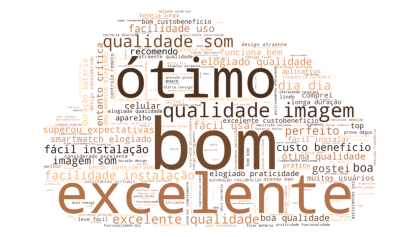

In [35]:
# preparar dados para o worcloud
smartObjectsReviews['textoFiltradoJunto'] = smartObjectsReviews['textofiltrado'].str.join(', ')
texto = " ".join(s for s in smartObjectsReviews['textoFiltradoJunto'])
texto = texto.replace('além', '')
texto = texto.replace('disso', '')
texto = texto.replace('produto', '')

# chamando a função
nuvempalavrasgerar(texto, "smartObjectsReviews2", 'copper_r')

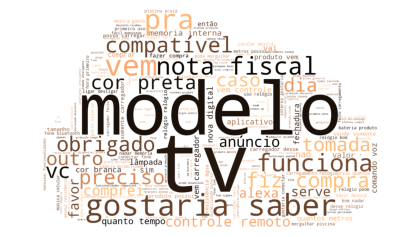

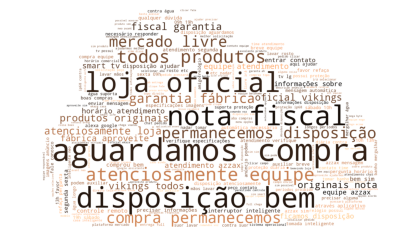

In [36]:
smartObjectsQuestions["perguntaFiltradoJunto"] = smartObjectsQuestions["perguntaFiltrado"].str.join(', ')
smartObjectsQuestions["respostaFiltradoJunto"] = smartObjectsQuestions["respostaFiltrado"].str.join(', ')

texto_perguntas = " ".join(s for s in smartObjectsQuestions['perguntaFiltradoJunto'])
texto_perguntas = texto_perguntas.replace("bom, dia", "")
texto_perguntas = texto_perguntas.replace("boa, tarde", "")
texto_perguntas = texto_perguntas.replace("boa, noite", "")
texto_perguntas = texto_perguntas.replace("olá", "")
texto_perguntas = texto_perguntas.replace("ola", "")
texto_perguntas = texto_perguntas.replace("tudo, bem", "")

texto_respostas = " ".join(s for s in smartObjectsQuestions['respostaFiltradoJunto'])
texto_respostas = texto_respostas.replace("olá, tudo", "")
texto_respostas = texto_respostas.replace("tudo, bem", "")
texto_respostas = texto_respostas.replace("olá", "")
texto_respostas = texto_respostas.replace("boa, tarde", "")
texto_respostas = texto_respostas.replace("bom, dia", "")
texto_respostas = texto_respostas.replace("boa, noite", "")

nuvempalavrasgerar(texto_perguntas, "smartObjectsPerguntas2", 'copper_r')
nuvempalavrasgerar(texto_respostas, "smartObjectsRespostas2", 'copper_r')

In [10]:
def analisesentimentosBlob(texto):
  # Cria o objeto TextBlob
  blob = TextBlob(texto)

  # Pega o sentimento
  # se > 0.1 é positivo, se 0 é neutro e se < -0.1 é negativo
  sentimento = blob.sentiment
  return sentimento.polarity

def analisesentimentosLeIA(texto):
  # Cria o objeto LeIA
  s = SentimentIntensityAnalyzer()


  # Pega o sentimento
  # se > 0.05 é positivo, entre é neutro e se < -0.05 é negativo
  sentimento = s.polarity_scores(texto)
  return sentimento["compound"]



In [ ]:
# gerando dados
smartObjectsReviews['sentimento'] = smartObjectsReviews['texto'].apply(analisesentimentosLeIA)
smartObjectsReviews

In [ ]:
smartObjectsQuestions['sentimento'] = smartObjectsQuestions["pergunta"].apply(analisesentimentosLeIA)
smartObjectsQuestions

,pergunta,resposta,id,data,sentimento
0,Qual tamanho do cabo 12V,"Olá, boa tarde! Cerca de 2M!",MLB36333923,28/08/2025,0.0000
1,Ela não congela só esfria,"Olá, boa tarde! Isso, ela é uma geladeira, dif...",MLB36333923,15/07/2025,-0.3182
2,"Boa tarde Estou precisando de duas placas , pr...","Olá, bom dia! Infelizmente não temos peças de ...",MLB36333923,14/07/2025,0.6036
3,Tem o link só do cabo de alimentação dessa mes...,"Olá boa noite, No momento não temos estoque so...",MLB36333923,12/07/2025,0.0000
4,Boa tarde preciso da 220 mas somente a 110 est...,"Oi, Luiz acurcio Abreu! Tudo bem? Neste anúnci...",MLB54448099,13/11/2025,0.0129
...,...,...,...,...,...
14640,"Olá vendedor, a lâmpada é compatível com rede ...","Olá, A lâmpada Xiaomi Inteligente Wifi Smart L...",MLB37232290,02/12/2025,0.0000
14641,É 127v ou 220v?,"Boa tarde, agradecemos pelo contato! Ela é biv...",MLB43919988,10/11/2025,0.0000
14642,Posso sintonizar a cor pelo app?,"Boa tarde, agradecemos pelo contato! Sim, pelo...",MLB43919988,10/11/2025,0.0000
14643,"Olá, consigo deixar sempre no branco?","É só altera de cor pelo aplicativo, a última c...",MLB43919988,30/05/2025,0.0000


In [12]:
# função de avaliação final
def tiposentimento(x):
  if x > 0.05:
    return 'Positivo'
  if x < -0.05:
    return 'Negativo'
  else:
    return 'Neutro'



In [ ]:
smartObjectsQuestions['tiposentimento'] = smartObjectsQuestions['sentimento'].apply(tiposentimento)
smartObjectsQuestions['tiposentimento'].value_counts()


tiposentimento
Neutro      6794
Positivo    4869
Negativo    2982
Name: count, dtype: int64

In [ ]:
# chamando a geração 
smartObjectsReviews['tiposentimento'] = smartObjectsReviews['sentimento'].apply(tiposentimento)

smartObjectsReviews['tiposentimento'].value_counts()

tiposentimento
Positivo    3046
Neutro       641
Negativo     409
Name: count, dtype: int64

In [ ]:
smartObjectsReviews["nota"].value_counts()


nota
5    3591
4     316
1      67
3      23
2      22
Name: count, dtype: int64

In [ ]:
reviews_ruins = smartObjectsReviews[(smartObjectsReviews['tiposentimento'] != 'Positivo') & (smartObjectsReviews["nota"] <= '3')].reset_index(drop=True) 
reviews_ruins['textofiltrado'] = reviews_ruins['textofiltrado'].str.join(', ')
texto = " ".join(s for s in reviews_ruins['textofiltrado'])

texto = texto.replace('produto', '')
texto = texto.replace('pra', '')
texto = texto.replace('quer', '')
texto = texto.replace('nootbok', '')

nuvempalavrasgerar(texto, "reviews_ruins", 'copper_r')

In [ ]:
Rótulos, quantidade
Defeitos de Bateria/Carregamento, 11
Falha Funcional Crítica, 83
Falhas de Pareamento/Conectividade, 13
Limitações de recursos esperados, 17
Recursos anunciados não satisfeitos, 25
Geração de Nota Fiscal e Preço, 98
Dificuldade de Configuração, 80
Danos Físicos e Falha na Logística, 75
Falha de Comunicação com Suporte, 59
Problemas de Entrega / Pedido Errado, 55